In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# these are used as global variables!
ALGORITHMS = [f'A{i}' for i in range(3)]
CLIENTS = {
    "random_client": {"N": 50, "type": 'random'},
    "ideal_client": {"N": 50, "type": 'ideal'},
    "small_random_client": {"N": 10, "type": 'random'},
    "large_random_client": {"N": 250, "type": 'random'},
}

REGIONS = {
    'WT': 1,
    'TC': 2,
    'ET': 4
}
METRICS = {
    'dice': {'range': [0, 1], 'mode': 'max'},
    'hd95': {'range': [0, np.infty], 'mode': 'min'}
}

In [3]:
def sigmoid(x):
    mask = x >= 0   # for arrays
    result = np.zeros_like(x)
    # for numerical stability
    result[mask] = 1 / (1 + np.exp(-x[mask]))
    z = np.exp(x[~mask])
    result[~mask] = z / (1 + z)
    return  result

def sample_random(idx, n, hd95=False):
    # idx not used; could use it to introduce some shift
    if hd95:
        return np.random.gamma(2, 3, n)
    return sigmoid(np.random.randn(n) * 1. + 1.5)


def sample_ideal(idx, n, hd95=False):
    # fuck it, let's hard-code it
    if hd95:
        ub = 20.
        lb = 0.
        delta = (ub - lb) / len(ALGORITHMS)
        return ub - delta * (idx + np.random.rand(n))
    ub = 1.0
    lb = 0.4
    delta = (ub - lb) / len(ALGORITHMS)
    return lb + delta * (idx + np.random.rand(n))

def simulate_client(name, num_cases, sample_fn, **sample_kwargs):
    # per hospital workflow
    df = None
    for idx, alg in enumerate(ALGORITHMS):
        tmp_df = pd.DataFrame(
            {
                'case': [i for i in range(num_cases)],
                'alg_name': [alg] * num_cases,
            }
        )
        for lab in REGIONS:
            for m in METRICS:
                hd95 = True if m == 'hd95' else False
                tmp_df[f"{lab}-{m}"] = sample_fn(idx, num_cases, hd95=hd95)

        if df is None:
            df = tmp_df
        else:
            df = df.append(tmp_df, ignore_index=True)

    df.insert(0, 'client', name)
    return df

client_type2fct = {
    'random': sample_random,
    'ideal': sample_ideal
}

From challengeR-repo:

Data requires the following columns:

- task identifier in case of multi-task challenges (string or numeric)
- test case identifier (string or numeric)
- algorithm identifier (string or numeric)
- metric value (numeric)


In [6]:
import random

df = None
for client_name, client_setup in CLIENTS.items():
    print(f"Simulating {client_name}")

    tmp = simulate_client(client_name, client_setup['N'], client_type2fct[client_setup['type']])
    tmp.to_csv(f"data/{client_name}.csv")
    # appending is optional; could also save individual csv's for all hospitals
    if df is None:
        df = tmp
    else:
        df = df.append(tmp, ignore_index=True)
# df.to_csv("data/clients_pooled.csv")

Simulating random_client
Simulating ideal_client
Simulating small_random_client
Simulating large_random_client


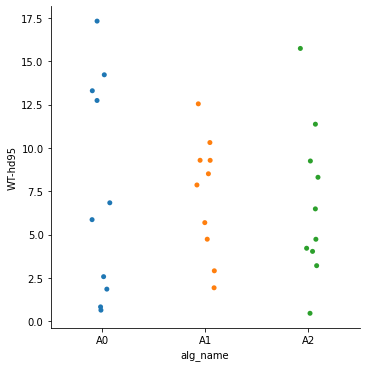

In [5]:
sns.catplot(x='alg_name', y='WT-hd95', data=df.loc[df.client == 'small_random_client', :])
# plt.ylim([0,1])

TODO:
- simulate some mixed clients (random, ideal, other??)